In [228]:
%reload_ext autoreload
%autoreload 2

In [229]:
import torch

from sbi import utils as utils
from sbi.analysis import pairplot
from sbi.inference import NSPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [230]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(theta):
    # linear gaussian
    return theta + 1.0 + torch.randn_like(theta) * 0.1

# Check prior, simulator, consistency
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

In [231]:
# Create inference object. Here, NPE is used.
inference = NSPE(prior=prior, sde_type="vp", weight_fn="max_likelihood")

# generate simulations and pass to the inference object
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2_000)
inference = inference.append_simulations(theta, x)

# train the density estimator and build the posterior
density_estimator = inference.train(stop_after_epochs=100)
posterior = inference.build_posterior(density_estimator)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 939 epochs.

/root/sbi/sbi/inference/posteriors/score_posterior.py:67: UserWarning: x_shape is not None. However, passing x_shape to the `Posterior` is deprecated and will be removed in a future release of `sbi`.
  theta_transform=theta_transform,


(<Figure size 2000x600 with 2 Axes>,
 array([<Axes: xlabel='epochs_trained', ylabel='training_loss'>,
        <Axes: xlabel='epochs_trained', ylabel='validation_loss'>],
       dtype=object))

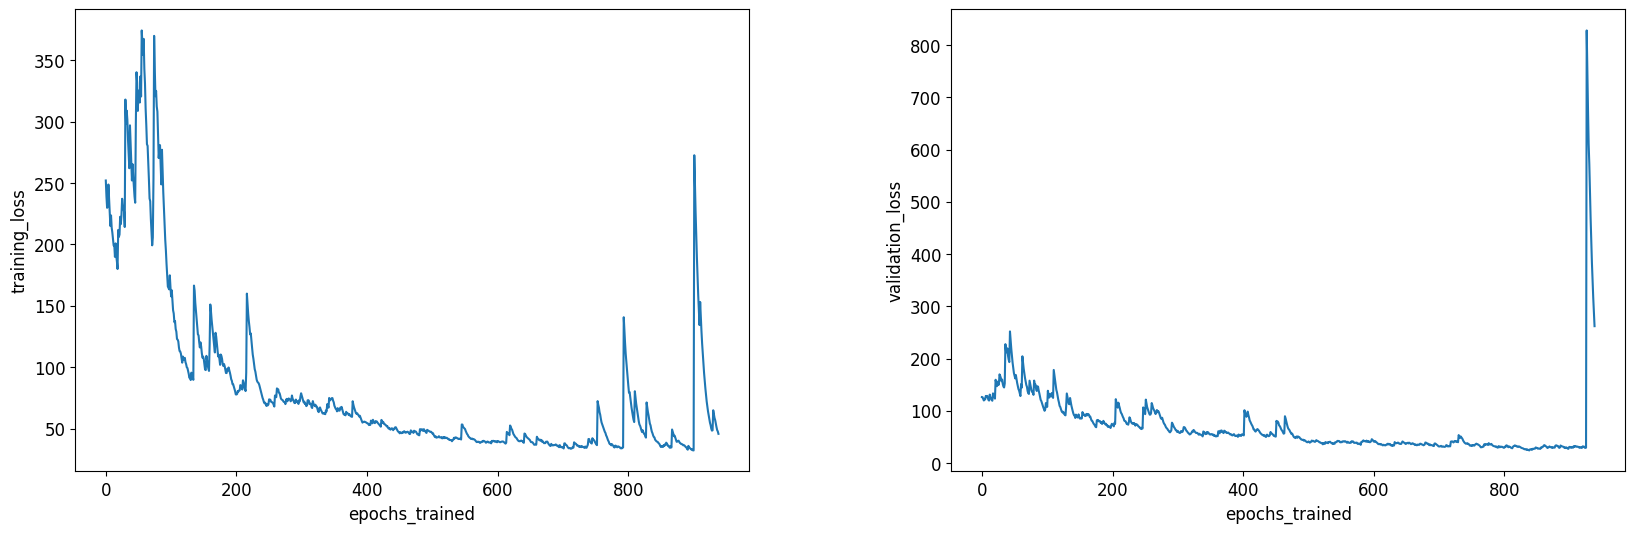

In [232]:
from sbi.analysis import plot_summary

plot_summary(inference, tags=["training_loss", "validation_loss"])

In [273]:
posterior = inference.build_posterior(density_estimator)

/root/sbi/sbi/inference/posteriors/score_posterior.py:69: UserWarning: x_shape is not None. However, passing x_shape to the `Posterior` is deprecated and will be removed in a future release of `sbi`.
  super().__init__(


In [274]:
theta_true = prior.sample((1,))
# generate our observation
x_obs = simulator(theta_true)

In [280]:
samples = posterior.sample((10000,), x=x_obs)

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

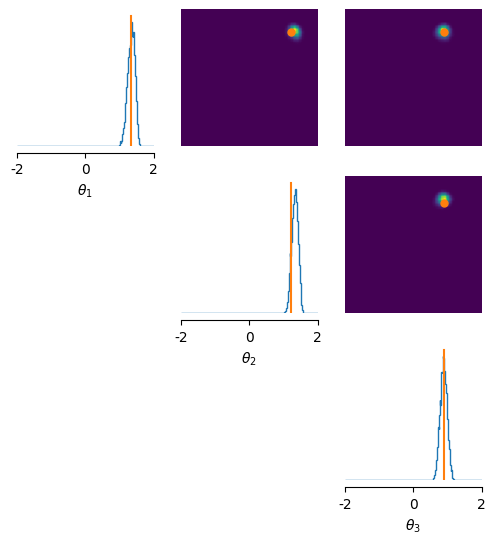

In [278]:
#samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

In [276]:
samples.shape

torch.Size([10000, 3])

In [262]:
from sbi.samplers.score.predictors import EulerMaruyama
from sbi.samplers.score.score import Diffuser

diffuser = Diffuser(posterior.potential_fn, EulerMaruyama(posterior.potential_fn))

In [272]:
posterior.potential_fn.x_o.shape

torch.Size([1, 3, 1])

In [270]:
diffuser.batch_shape

torch.Size([1, 3])

In [264]:
diffuser.initialize(100).shape

torch.Size([3, 100, 3])

In [268]:
theta0 = diffuser.initialize(100)

In [269]:
theta0.shape

torch.Size([3, 100, 3])

In [267]:
samples = diffuser.run(1000, ts=torch.linspace(1., 1e-3, 500))

Drawing 1000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (1000) must match the size of tensor b (3) at non-singleton dimension 1

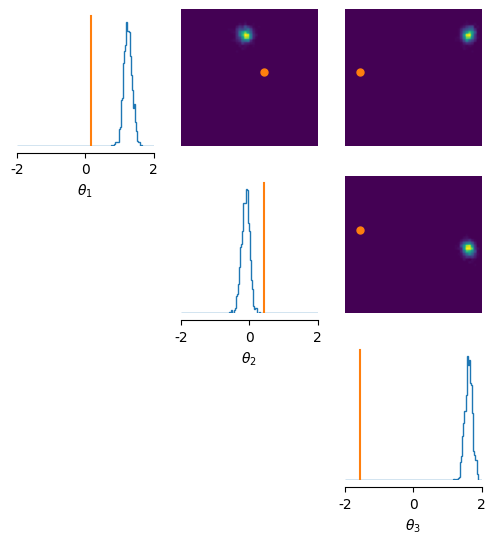

In [225]:
#samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples[0], points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

In [124]:
ts = torch.linspace(0, 1, 1000)
s_t = density_estimator.std_fn(ts)
g_t = density_estimator.diffusion_fn(torch.ones((1,1)),ts)

In [125]:
def p(ts):
    return torch.squeeze(density_estimator.diffusion_fn(torch.ones((1,1)),ts)**2/density_estimator.std_fn(ts)**2)

In [126]:
import matplotlib.pyplot as plt

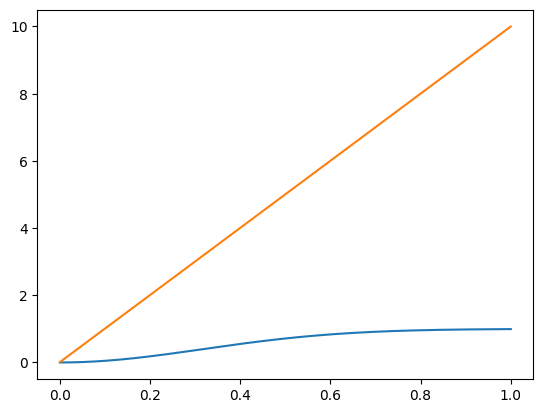

In [127]:
plt.plot(ts, s_t**2)
plt.plot(ts, g_t**2)

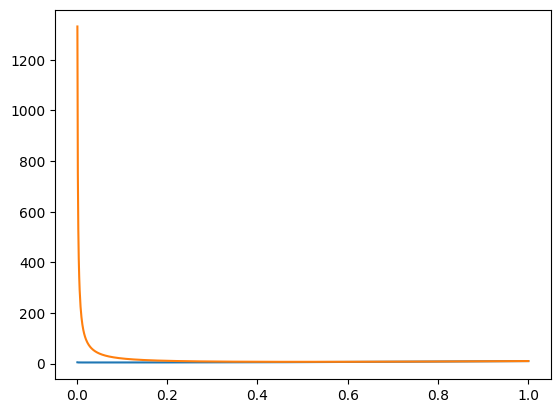

In [129]:
plt.plot(ts, g_t**2/s_t)
plt.plot(ts, p(ts))

In [130]:
def compute_inverse_cdf(p, num_points=2000, min_val=1e-3, max_val=1.0):
    t = torch.linspace(min_val, max_val, num_points)  # Discretize the interval [T_min, T_max]
    p_values = p(t)
    cdf = torch.cumsum(p_values, dim=0)
    cdf = cdf / cdf[-1]  # Normalize the CDF
    cdf = torch.cat([torch.zeros(1), cdf])  # Prepend 0 to the CDF

    def icdf(u):
        # Find where each u fits into the CDF
        indices = torch.searchsorted(cdf, u, right=False)

        # Ensure indices are within valid range
        indices = torch.clamp(indices, 1, num_points - 1)

        # Linear interpolation
        u_lower = t[indices - 1]
        u_upper = t[indices]
        cdf_lower = cdf[indices - 1]
        cdf_upper = cdf[indices]

        return u_lower + (u - cdf_lower) * (u_upper - u_lower) / (cdf_upper - cdf_lower)

    return icdf

def inverse_transform_sampling(h, num_samples):
    icdf = compute_inverse_cdf(h)
    u = torch.rand(num_samples)
    return icdf(u)

In [131]:
t = torch.linspace(1e-3, 1., 200)  # Discretize the interval [T_min, T_max]
h_values = p(t)

In [132]:
cdf = torch.cumsum(h_values, dim=0)
cdf = cdf / cdf[-1]  # Normalize the CDF
cdf = torch.hstack([torch.zeros(1), cdf])

In [133]:
icdf_fn = compute_inverse_cdf(p, num_points=1000, T_min=1e-3, T_max=1.0)

TypeError: compute_inverse_cdf() got an unexpected keyword argument 'T_min'

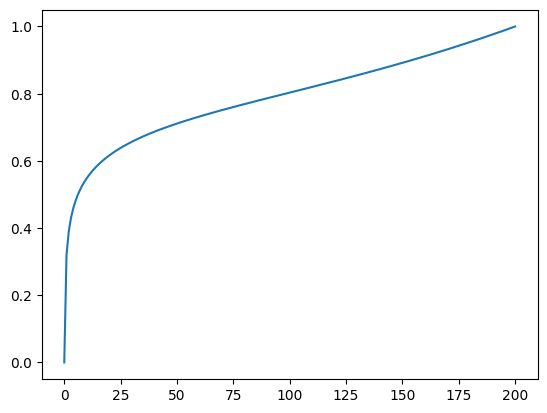

In [134]:
plt.plot(cdf)

(array([31.24590598,  6.91015164,  6.30927006,  4.20617847,  3.30485636,
         1.40205975,  2.90426663,  1.30191311,  1.60235341,  0.90132446,
         1.20176505,  1.6023546 ,  1.70250176,  2.00294176,  1.30191214,
         0.70103066,  0.60088253,  0.40058835,  1.10161797,  1.40206132,
         0.50073544,  0.8011767 ,  0.60088342,  0.20029418,  0.90132514,
         0.30044082,  0.30044171,  0.40058895,  0.50073469,  0.20029447,
         0.70102857,  0.40058895,  0.40058895,  0.80117551,  0.70103066,
         0.30044171,  0.20029388,  0.20029447,  0.40058895,  0.40058775,
         0.70103066,  0.30044171,  0.30044082,  0.50073619,  0.50073619,
         0.30044082,  0.30044171,  0.80117551,  0.60088342,  0.60088342,
         0.10014694,  0.40059014,  0.10014694,  0.40058775,  0.40058775,
         0.20029507,  0.10014694,  0.50073469,  0.        ,  0.20029388,
         0.30044082,  0.50073768,  0.20029388,  0.20029388,  0.20029507,
         0.50073469,  0.30044082,  0.20029507,  0.5

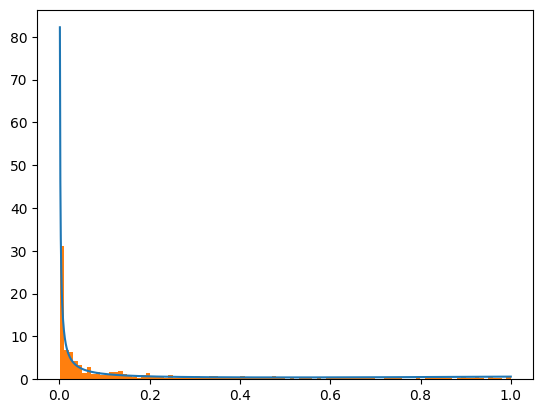

In [135]:
samples = icdf_fn(torch.rand(1000))
plt.plot(ts[1:], p(ts[1:])/torch.trapz(p(ts[1:]),ts[1:]))
plt.hist(samples, bins=100, density=True)

In [109]:
icdf = compute_inverse_cdf(p)

icdf(ts[1])

tensor(0.0010)